In [25]:
import pandas as pd
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Vader Analysis

In [26]:
vader = SentimentIntensityAnalyzer()

In [27]:
def analyze_vader(text):
    scores = vader.polarity_scores(text)
    return scores['compound']  # Main sentiment score [-1, 1]

def add_vader_sentiment(df, text_column='dialogue'):
    df['vader_sentiment'] = df[text_column].apply(analyze_vader)
    return df

## BERT

In [28]:
# === BERT Setup ===
model_name = "kornosk/polibertweet-mlm"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

def analyze_bert(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    with torch.no_grad():
        logits = model(**inputs).logits
    probs = torch.nn.functional.softmax(logits, dim=-1).squeeze().numpy()
    return float(probs[1])  # Probability of positive sentiment

def add_bert_sentiment(df, text_column='dialogue'):
    df['bert_sentiment'] = (2*(df[text_column].apply(analyze_bert)))-1  # Scale to [-1, 1]
    return df

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at kornosk/polibertweet-mlm and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Comparison Values

In [29]:
def add_diff_sentiment(df, text_column='dialogue'):
    df = add_vader_sentiment(df, text_column)
    df = add_bert_sentiment(df, text_column)
    df['diff_sentiment'] = df['bert_sentiment'] - df['vader_sentiment']
    return df

## First Test

In [30]:
with open('debate_transcripts_cleaned.csv', 'r') as f:
    df = pd.read_csv(f)
#    df = add_diff_sentiment(df, text_column='dialogue')
#    df.to_csv('debate_transcripts_sentiment.csv', index=False)

In [31]:
df.head()

,year,date,actor,dialogue,is_candidate,party,is_winner,VP_debate,is_incumbent
0,1960,1960-09-26,Kennedy,"Mr. Smith, Mr. Nixon. In the election of 1860,...",True,Democratic,True,False,False
1,1960,1960-09-26,Smith,And now the opening statement by Vice Presiden...,False,NaN,False,False,False
2,1960,1960-09-26,Nixon,"Mr. Smith, Senator Kennedy. The things that Se...",True,Republican,False,False,False
3,1960,1960-09-26,Smith,"Thank you, Mr. Nixon. That completes the openi...",False,NaN,False,False,False
4,1960,1960-09-26,Fleming,"Senator, the Vice President in his campaign ha...",False,NaN,False,False,False


In [32]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize lemmatizer and stopwords
lem = WordNetLemmatizer()
stop_words = stopwords.words('english')

def data_preprocess(text):
    # Tokenize text
    wtokens = word_tokenize(text)

    # Filtering tokens
    t_filtered = [t.lower() for t in wtokens if t.lower() not in stop_words and t.isalpha()]

    # Lemmatization
    t_lemmatized = [lem.lemmatize(t) for t in t_filtered]

    return " ".join(t_lemmatized)

# Apply preprocessing to the 'dialogue' column
df['cleaned_text'] = df['dialogue'].apply(data_preprocess)

# Display the first 15 entries of original and cleaned columns
df[['dialogue', 'cleaned_text']].head(15)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...


,dialogue,cleaned_text
0,"Mr. Smith, Mr. Nixon. In the election of 1860,...",smith nixon election abraham lincoln said ques...
1,And now the opening statement by Vice Presiden...,opening statement vice president richard nixon
2,"Mr. Smith, Senator Kennedy. The things that Se...",smith senator kennedy thing senator kennedy sa...
3,"Thank you, Mr. Nixon. That completes the openi...",thank nixon completes opening statement candid...
4,"Senator, the Vice President in his campaign ha...",senator vice president campaign said naive tim...
5,"Well, the Vice President and I came to the Con...",well vice president came congress together ser...
6,"Mr. Nixon, would you like to comment on that s...",nixon would like comment statement
7,I have no comment.,comment
8,The next question: Mr. Novins.,next question novins
9,"Mr. Vice President, your campaign stresses the...",vice president campaign stress value eight yea...


In [35]:
df_vader = add_vader_sentiment(df, text_column='cleaned_text')
df_vader = df_vader[(df_vader["is_candidate"]) & (~df_vader["VP_debate"])]

In [36]:
df_vader 

,year,date,actor,dialogue,is_candidate,party,is_winner,VP_debate,is_incumbent,cleaned_text,vader_sentiment
0,1960,1960-09-26,Kennedy,"Mr. Smith, Mr. Nixon. In the election of 1860,...",True,Democratic,True,False,False,smith nixon election abraham lincoln said ques...,0.9995
2,1960,1960-09-26,Nixon,"Mr. Smith, Senator Kennedy. The things that Se...",True,Republican,False,False,False,smith senator kennedy thing senator kennedy sa...,0.9982
5,1960,1960-09-26,Kennedy,"Well, the Vice President and I came to the Con...",True,Democratic,True,False,False,well vice president came congress together ser...,0.9851
7,1960,1960-09-26,Nixon,I have no comment.,True,Republican,False,False,False,comment,0.0000
10,1960,1960-09-26,Nixon,It would be rather difficult to cover them in ...,True,Republican,False,False,False,would rather difficult cover eight two half mi...,0.9756
...,...,...,...,...,...,...,...,...,...,...,...
9740,2024,2024-09-10,Harris,"Well, the former president had said that clima...",True,Democratic,False,False,False,well former president said climate change hoax...,0.9775
9742,2024,2024-09-10,Trump,That didn't happen under Donald Trump. Let me ...,True,Republican,True,False,False,happen donald trump let tell lost manufacturin...,-0.1311
9744,2024,2024-09-10,Trump,Thank you.,True,Republican,True,False,False,thank,0.3612
9747,2024,2024-09-10,Harris,So I think you've heard tonight two very diffe...,True,Democratic,False,False,False,think heard tonight two different vision count...,0.9919


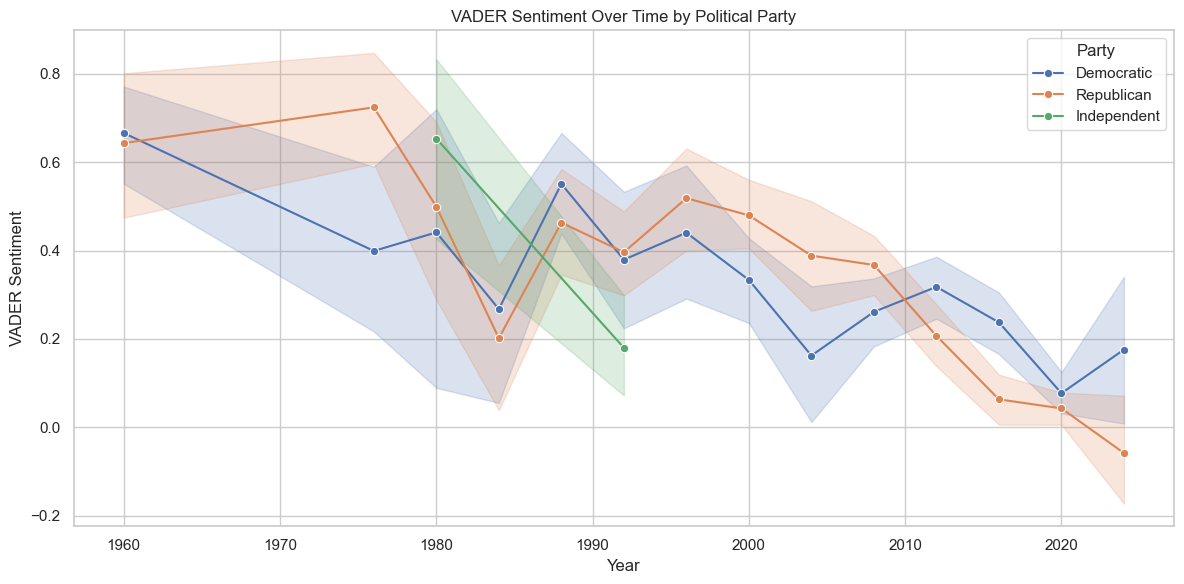

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the plot style
sns.set(style='whitegrid')

# Create the plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_vader, x='year', y='vader_sentiment', hue='party', marker='o')

# Add labels and title
plt.title('VADER Sentiment Over Time by Political Party')
plt.xlabel('Year')
plt.ylabel('VADER Sentiment')
plt.legend(title='Party')
plt.tight_layout()
plt.show()